In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

Autosaving every 60 seconds


[Memory]0.0s, 0.0min    : Loading read_series_sample...
__________________________________read_series_sample cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading melt_sales_series...
___________________________________melt_sales_series cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading extract_day_ids...
_____________________________________extract_day_ids cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading join_w_calendar...
_____________________________________join_w_calendar cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading join_w_prices...
_______________________________________join_w_prices cache loaded - 0.0s, 0.0min


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,root_mean_squared_error,wrmsse,time
0,82.109962,141.160294,11.881089,0.000000,00:08
1,79.242271,141.160294,11.881089,0.000000,00:07
2,78.803864,141.160294,11.881089,0.000000,00:07
3,79.744507,141.160294,11.881089,0.000000,00:07
4,80.187729,141.160294,11.881089,0.000000,00:08


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945
y_pred,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94
y_val,13.92,1.92,1.44,5.94,8.38,32.48,0.96,8.38,9.28,0.48,5.94


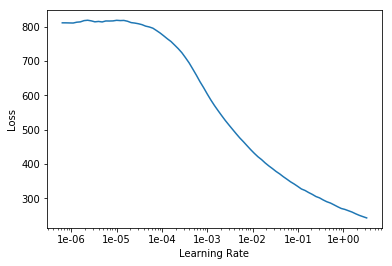

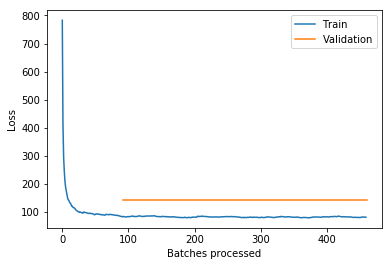

In [19]:
# %load ivanocode/pipeline/pipeline.py 
from ivanocode.pipeline.wrmsse import wrmsse_total, with_aggregate_series
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib

raw = 'raw'
processed = 'processed'
submissions = 'submissions'
tmp = 'tmp'

n_days_total = 1913
trn_days = 1910
n_total_series = 30490
n_sample_series = 10

from joblib import Memory
location = './tmp'
memory = Memory(location, verbose=5)

@memory.cache
def read_series_sample(n = 10):
    sample_idx = set(np.random.choice(
        range(1, n + 1),
        n
    ))

    # header
    sample_idx.add(0)

    return pd.read_csv(f'{raw}/sales_train_validation.csv', skiprows = lambda i: i not in sample_idx)

@memory.cache
def melt_sales_series(df_sales_train):
    id_columns = [col for col in df_sales_train.columns if 'id' in col]
    sales_columns = [col for col in df_sales_train.columns if 'd_' in col]
    cat_columns = [col for col in id_columns if col != 'id']

    df_sales_train_melt = df_sales_train.melt(
        id_vars=id_columns,
        var_name='day_id',
        value_name='sales'
    )

    for col in id_columns:
        df_sales_train_melt[col] = df_sales_train_melt[col].astype('category')

    df_sales_train_melt['sales'] = df_sales_train_melt['sales'].astype('int16')

    return df_sales_train_melt

@memory.cache
def extract_day_ids(df_sales_train_melt):
    sales_columns = [f'd_{col}' for col in range(1, n_days_total+1)]
    mapping = {col: int(col.split('_')[1]) for col in sales_columns}
    df_sales_train_melt['day_id'] = df_sales_train_melt['day_id'].map(mapping)

    import datetime
    d_1_date = pd.to_datetime('2011-01-29')
    mapping = {day:(d_1_date + datetime.timedelta(days=day-1)) for day in range(1, n_days_total+1)}
    df_sales_train_melt['day_date'] = df_sales_train_melt['day_id'].map(mapping)

    mapping = {day:str((d_1_date + datetime.timedelta(days=day-1)).date()) for day in range(1, n_days_total+1)}
    # gonna need it for joining with calendars & stuff
    df_sales_train_melt['day_date_str'] = df_sales_train_melt['day_id'].map(mapping)

    df_sales_train_melt['day_date_str'] = df_sales_train_melt['day_date_str'].astype('category')
    df_sales_train_melt['day_id'] = df_sales_train_melt['day_id'].astype('int16')
    df_sales_train_melt['month_id'] = df_sales_train_melt['day_date'].dt.month.astype('uint8')

    return df_sales_train_melt

@memory.cache
def join_w_calendar(df_sales_train_melt):
    df_calendar = pd.read_csv(f'{raw}/calendar.csv')
    df_sales_train_melt =  df_sales_train_melt.merge(
        df_calendar[['date', 'wm_yr_wk']],
        left_on='day_date_str', right_on='date',
        validate='many_to_one')

    df_sales_train_melt['wm_yr_wk'] = df_sales_train_melt['wm_yr_wk'].astype('int16')
    return df_sales_train_melt

@memory.cache
def join_w_prices(partition):
    df_prices = pd.read_csv(f'{raw}/sell_prices.csv')
    partition = partition.merge(
        df_prices,
        on=['store_id', 'item_id', 'wm_yr_wk'],
        how='left'
    )
    partition['sell_price'] = partition['sell_price'].astype('float32')
    partition['sales_dollars'] = (partition['sales'] * partition['sell_price']).astype('float32')
    partition.fillna({'sales_dollars': 0}, inplace=True)
    return partition

from fastai.tabular import *
from IPython.display import display


def _wrmsse(y, val, trn):
    pred = val.copy()
    pred['sales_dollars'] = y
    display(pd.DataFrame({'y_pred': y, 'y_val': val['sales_dollars']}).transpose())
    # TODO: rounding differently might be important for sporadic sales on lower-volume items
    pred['sales'] = pred['sales_dollars'] / pred['sell_price']
    pred['sales'].fillna(0, inplace=True)
    pred['sales'] = pred['sales'].astype('int')
    val_w_aggs = with_aggregate_series(val.copy())
    trn_w_aggs = with_aggregate_series(trn.copy())
    pred_w_aggs = with_aggregate_series(pred.copy())
    score = wrmsse_total(
        trn_w_aggs,
        val_w_aggs,
        pred_w_aggs
    )
    return score

from fastai.callbacks import *
# mega workaroundish way of plugging a metric func designed to work with all the data to run after each epoch 
# fast.ai is designed around per batch metrics + aggregating them
class MyMetrics(LearnerCallback):
    # should run before the recorder
    _order = -30
    def __init__(self, learn, trn, val):
        super().__init__(learn)
        self.trn = trn
        self.val = val
        self.learn = learn

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['wrmsse'])
        pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        rec = self.learn.recorder
        preds, y_val = self.learn.get_preds(DatasetType.Valid)
        y_pred = preds.numpy().flatten()
        self.learn.recorder = rec
        score = _wrmsse(y_pred, self.val, self.trn)
        return {'last_metrics': last_metrics + [score]}

def model_as_tabular(df_sales_train_melt):
    df_sample = df_sales_train_melt.query('sales_dollars > 0').reset_index(drop=True)
    valid_idx = np.flatnonzero(df_sample['day_id'] > trn_days)

    val_mask = df_sample.index.isin(valid_idx)
    val = df_sample[val_mask]
    trn = df_sample[~val_mask]

    my_metrics_cb = partial(MyMetrics, val=val, trn=trn)

    procs = [FillMissing, Categorify, Normalize]
    dep_var = 'sales_dollars'
    cat_names = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month_id', 'id']
    cols = cat_names + ['sell_price'] + [dep_var]

    path ='./tmp'
    data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                    procs=procs, cat_names=cat_names)

    sales_range = df_sales_train_melt.agg({dep_var: ['min', 'max']})
    learn = tabular_learner(data, layers=[1000,1000], emb_szs=None, metrics=[rmse], 
                        y_range=sales_range[dep_var].values, callback_fns=[my_metrics_cb],
                        use_bn=False,
                        wd=0)
    # Note to self: default wd seem to big - results converged to basically nothing in the first ep
    learn.lr_find()
    fig = learn.recorder.plot(return_fig=True)
    fig.savefig('lr_find.png')
    !open lr_find.png
    learn.fit_one_cycle(5, 1e1)
    fig = learn.recorder.plot_losses(return_fig=True)
    fig.savefig('loss_log.png')

    """
    the above is pretty unstable, still we sort of got it to overfit slightly
    epoch     train_loss  valid_loss  root_mean_squared_error  time    
    0         83.365913   53.201424   7.188121                 00:00                                                                                      
    1         56.507870   55.011505   7.313859                 00:00                                                                                      
    2         48.014706   55.011673   7.313872                 00:00                                                                                      
    3         44.242149   55.001785   7.313148                 00:00                                                                                      
    4         42.347946   57.570885   7.462979                 00:00 
    epoch     train_loss  valid_loss  root_mean_squared_error  time    
    0         99.312691   88.176826   9.289624                 00:00                                                                                      
    1         53.812771   45.480507   6.625162                 00:00                                                                                      
    2         35.418938   19.952007   4.353195                 00:00                                                                                      
    3         23.099392   17.516432   4.008787                 00:00                                                                                      
    4         17.082275   17.641117   4.019526                 00:00 
    """
    return learn, trn, val

sales_series = read_series_sample(n_sample_series)
sales_series = melt_sales_series(sales_series)
sales_series = extract_day_ids(sales_series)
sales_series = join_w_calendar(sales_series)
sales_series = join_w_prices(sales_series)
learn, trn, val = model_as_tabular(sales_series)

In [ ]:
preds, y_val = learn.get_preds(DatasetType.Valid)

In [15]:
# TODO: how do we get zeroes here if they were supposed to be filtered by the query above? :/
(trn['sales_dollars'] == 0).sum() / float(len(trn))

0.0

In [16]:
(val['sales_dollars'] == 0).sum() / float(len(val))

0.0

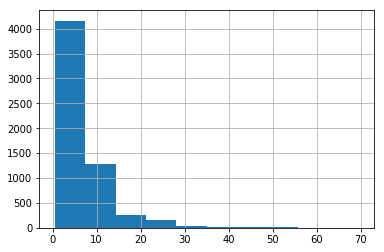

In [17]:
trn['sales_dollars'].hist()

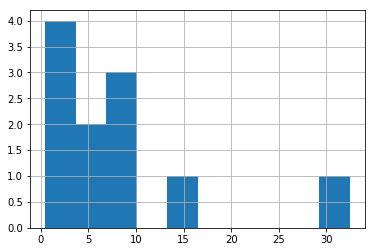

In [18]:
val['sales_dollars'].hist()

In [ ]:
"""
149.428452	141.160263	11.881088	0	00:03
1	92.145798	141.160294	11.881089	0	00:02
2	83.048798	141.160248	11.881088	0	00:02
3	82.048836	141.160294	11.881089	0	00:02
4	81.270966	141.160294	11.881089	0	00:02

# preds don't seem to change with reruns
tensor([13.9200,  1.9200,  1.4400,  5.9400,  8.3800, 32.4800,  0.9600,  8.3800,
         9.2800,  0.4800,  5.9400])
"""
val['id'].value_counts().sort_index()

In [ ]:
trn['id'].value_counts().sort_index()

In [ ]:
pd.read_csv(f'{raw}/calendar.csv', nrows=1)

In [ ]:
val

In [ ]:
# Karpathy's process for DNN end-to-end skeleton setup
# 0. Fix random seed
# 1. Simplify (e.g. no augmentations other unnecessary features)
# 2. When plotting the loss - run it over entire dataset
# 3. Verify loss @ {{c1::init}}
# 4. Init well
# 5. Human baseline
# 6. Input-independent baseline
# 7. Overfit {{c2::one batch}}
# 8. Verify decreasing training loss
# 9. Visualize what's fed into {{c3::the neural part of the model (stats after normalization etc)}}
# 10. Visualize prediction dynamics on {{c4::a single batch over the entire training}}
# 11. Use backprop to chart dependencies: {{c1::set loss for example to be 1, run backprop on it and make sure you get non-zero gradient on just that example}}
# 12. Start from a special case then generalize